<font size="7">Thesis file</font>
<br>

</font>

<font size="6">1. Install necessities</font>
<br>



In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import csv
import imblearn
import numpy as np

import os
import seaborn as sns
from sklearn import metrics
from collections import Counter
from matplotlib import pyplot
from numpy import where
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import zero_one_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
import gc
from imblearn.over_sampling import RandomOverSampler
import gc
from imblearn.under_sampling import RandomUnderSampler
!pip install pandas plotnine
import warnings
warnings.filterwarnings('ignore')
#from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_histogram
from sklearn.model_selection import cross_val_predict
from scipy import stats
from scipy.stats import wilcoxon
from sys import path




[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


<font size="6">2. Load and prepare data </font>
<br>



In [2]:
df = pd.read_csv("ESS10.csv", low_memory = False)

In [3]:
##Only include relevant variables
df_relevant_vars = df[['cntry', 'agea','hinctnta','eisced', 'eduyrs', 'sclmeet', 
                       'wrkhome', 'c19whome', 'wrklong', 'wrkresp', 'c19whacc', 
                       'mansupp','manwrkpl', 'manspeak', 'manscrn', 'manphone',
                       'mancom','teamfeel','wrkextra', 'colprop', 'colspeak', 'colscrn', 'colphone', 'colcom', 'c19spwrk', 'c19mcwrk',
                       'mcwrkhom','stfmjob', 'uemp3m', 'uemp12m','uemp5yr', 'emplrel',
                       'hincfel', 'gndr', 'trdawrk','jbprtfp', 'pfmfdjba', 'dcsfwrka', 
                       'c19wplch', 'manhlp',  'colhlp']].copy()
df_relevant_vars.stfmjob.count()

18060

df_relevant_vars includes only the vars that are used in this study, it leaves out all other variables assesed in the ESS. 

<font size="6">
    2a. Missing values

In [4]:
##Delete missing values from satisfied with job
values = [55, 66, 77, 88, 99]
df_SF_complete = df_relevant_vars[df_relevant_vars.stfmjob.isin(values) == False]
print('Individuals missing satisfaction score:', df_relevant_vars.stfmjob.count() - df_SF_complete.stfmjob.count(), 
     '\nRemaining = ', df_SF_complete.stfmjob.count()) 

Individuals missing satisfaction score: 8149 
Remaining =  9911


In [5]:
##General missing values 33, 55, 66, 77, 88, 99 set to NaN
for col in['hinctnta','eisced', 'eduyrs', 'sclmeet', 'wrkhome', 
           'c19whome', 'wrklong', 'wrkresp', 'c19whacc', 
            'mansupp','manwrkpl', 'manspeak', 'manscrn', 'manphone',
           'mancom','teamfeel','wrkextra', 'colprop', 'colspeak', 'colscrn' ,'colphone', 'colcom', 'c19spwrk', 'c19mcwrk','mcwrkhom']:
    df_SF_complete.loc[df_SF_complete[col] >= 33, col] = np.nan
for col in['agea']:
    df_SF_complete.loc[df_SF_complete[col] >= 999, col] = np.nan

df_SF_complete only includes the vars that have data for job satisfaction

In [6]:
##General missing values 55, 66, 77, 88, 99 set to NaN
for col in['uemp3m', 'uemp12m','uemp5yr', 'emplrel','hincfel', 'gndr', 'trdawrk',
           'jbprtfp', 'pfmfdjba', 'dcsfwrka', 'c19wplch', 'manhlp',  'colhlp', 
           'colscrn']:
    df_SF_complete.loc[df_SF_complete[col] >= 6, col] = np.nan

In [7]:
0.6 * df_SF_complete.stfmjob.count()

5946.599999999999

In [8]:
##Drop columns if more than 60% of data is missing. 
drop_cols = []
for col in ['cntry', 'agea','hinctnta','eisced', 'eduyrs', 'sclmeet', 
                       'wrkhome', 'c19whome', 'wrklong', 'wrkresp', 'c19whacc', 
                       'mansupp','manwrkpl', 'manspeak', 'manscrn', 'manphone',
                       'mancom','teamfeel','wrkextra', 'colprop', 'colspeak', 
                       'colscrn', 'colphone', 'colcom', 'c19spwrk', 'c19mcwrk',
                       'mcwrkhom','stfmjob', 'uemp3m', 'uemp12m','uemp5yr', 'emplrel',
                       'hincfel', 'gndr', 'trdawrk','jbprtfp', 'pfmfdjba', 'dcsfwrka', 
                       'c19wplch', 'manhlp',  'colhlp', 'colscrn']:
    if df_SF_complete[col].isna().sum() >= 0.6 * df_SF_complete.stfmjob.count():
        drop_cols.append(col)
        
print('the columns that are deleted are', drop_cols)
print(df_SF_complete.head())



the columns that are deleted are ['colscrn', 'uemp12m', 'uemp5yr', 'c19wplch', 'colscrn']
  cntry  agea  hinctnta  eisced  hhmmb  eduyrs  sclmeet  wrkhome  c19whome  \
1    BG  43.0       NaN     6.0    4.0    16.0      7.0      1.0       2.0   
2    BG  50.0       7.0     7.0    1.0    16.0      4.0      4.0       NaN   
3    BG  51.0       6.0     4.0    3.0    11.0      4.0      6.0       NaN   
4    BG  70.0       4.0     7.0    2.0    17.0      4.0      6.0       NaN   
7    BG  48.0       4.0     4.0    2.0    12.0      3.0      6.0       NaN   

   wrklong  ...  emplrel  hincfel  gndr  trdawrk  jbprtfp  pfmfdjba  dcsfwrka  \
1      6.0  ...      3.0      1.0   1.0      4.0      3.0       3.0       3.0   
2      6.0  ...      3.0      2.0   2.0      4.0      NaN       NaN       1.0   
3      NaN  ...      1.0      3.0   2.0      3.0      3.0       3.0       1.0   
4      NaN  ...      1.0      3.0   1.0      5.0      5.0       3.0       1.0   
7      NaN  ...      1.0      3.0   

In [9]:
##count NaN per row
missing = []
for i in range(len(df_SF_complete.index)):
    value = (df_SF_complete.iloc[i].isnull().sum())
    missing.append(value)
df_SF_complete['missing'] = missing
df_SF_complete.head()

,cntry,agea,hinctnta,eisced,hhmmb,eduyrs,sclmeet,wrkhome,c19whome,wrklong,...,hincfel,gndr,trdawrk,jbprtfp,pfmfdjba,dcsfwrka,c19wplch,manhlp,colhlp,missing
1,BG,43.0,NaN,6.0,4.0,16.0,7.0,1.0,2.0,6.0,...,1.0,1.0,4.0,3.0,3.0,3.0,2.0,NaN,3.0,10
2,BG,50.0,7.0,7.0,1.0,16.0,4.0,4.0,NaN,6.0,...,2.0,2.0,4.0,NaN,NaN,1.0,NaN,NaN,2.0,12
3,BG,51.0,6.0,4.0,3.0,11.0,4.0,6.0,NaN,NaN,...,3.0,2.0,3.0,3.0,3.0,1.0,NaN,2.0,2.0,10
4,BG,70.0,4.0,7.0,2.0,17.0,4.0,6.0,NaN,NaN,...,3.0,1.0,5.0,5.0,3.0,1.0,NaN,2.0,1.0,8
7,BG,48.0,4.0,4.0,2.0,12.0,3.0,6.0,NaN,NaN,...,3.0,1.0,3.0,3.0,3.0,1.0,NaN,1.0,1.0,11


In [10]:
##Delete individuals with XX amount of missing values
df_missing_deleted = df_SF_complete[df_SF_complete.missing <= 21].copy()
df_missing_deleted.missing.count()
print('There were:', 9911, 'individuals',
    '\nIndividuals missing too many values:', 9911 - df_missing_deleted.missing.count(),
     '\nRemaing individuals:', df_missing_deleted.missing.count())

There were: 9911 individuals 
Individuals missing too many values: 759 
Remaing individuals: 9152


In [11]:
df_missing_deleted.head()

,cntry,agea,hinctnta,eisced,hhmmb,eduyrs,sclmeet,wrkhome,c19whome,wrklong,...,hincfel,gndr,trdawrk,jbprtfp,pfmfdjba,dcsfwrka,c19wplch,manhlp,colhlp,missing
1,BG,43.0,NaN,6.0,4.0,16.0,7.0,1.0,2.0,6.0,...,1.0,1.0,4.0,3.0,3.0,3.0,2.0,NaN,3.0,10
2,BG,50.0,7.0,7.0,1.0,16.0,4.0,4.0,NaN,6.0,...,2.0,2.0,4.0,NaN,NaN,1.0,NaN,NaN,2.0,12
3,BG,51.0,6.0,4.0,3.0,11.0,4.0,6.0,NaN,NaN,...,3.0,2.0,3.0,3.0,3.0,1.0,NaN,2.0,2.0,10
4,BG,70.0,4.0,7.0,2.0,17.0,4.0,6.0,NaN,NaN,...,3.0,1.0,5.0,5.0,3.0,1.0,NaN,2.0,1.0,8
7,BG,48.0,4.0,4.0,2.0,12.0,3.0,6.0,NaN,NaN,...,3.0,1.0,3.0,3.0,3.0,1.0,NaN,1.0,1.0,11


df_missing_deleted only includes individuals that have enough data on all variables. 
the columns containing too few participants are already deleted here. 

In [12]:
#Bereken wat mode is per kolom
for col in ['cntry', 'agea','hinctnta','eisced', 'eduyrs', 'sclmeet', 
                       'wrkhome', 'c19whome', 'wrklong', 'wrkresp', 'c19whacc', 
                       'mansupp','manwrkpl', 'manspeak', 'manscrn', 'manphone',
                       'mancom','teamfeel','wrkextra', 'colprop', 'colspeak', 
                       'colscrn', 'colphone', 'colcom', 'c19spwrk', 'c19mcwrk',
                       'mcwrkhom','stfmjob', 'uemp3m', 'uemp12m','uemp5yr', 'emplrel',
                       'hincfel', 'gndr', 'trdawrk','jbprtfp', 'pfmfdjba', 'dcsfwrka', 
                       'c19wplch', 'manhlp',  'colhlp', 'colscrn']:
    print(df_missing_deleted[col].value_counts().idxmax())

##leftover van hoe ik missing verving met mode. df5['sclmeet'].fillna(4.0, inplace=True)

BG
41.0
8.0
4.0
2.0
12.0
4.0
6.0
3.0
5.0
5.0
3.0
8.0
1.0
3.0
7.0
3.0
7.0
10.0
0.0
1.0
1.0
3.0
3.0
7.0
3.0
3.0
0.0
8
2.0
2.0
2.0
1.0
2.0
2.0
3.0
3.0
3.0
1.0
1.0
1.0
1.0
3.0


In [13]:
#bereken wat mean is per kolom
for col in ['agea','hinctnta','eisced', 'eduyrs', 'sclmeet', 
                       'wrkhome', 'c19whome', 'wrklong', 'wrkresp', 'c19whacc', 
                       'mansupp','manwrkpl', 'manspeak', 'manscrn', 'manphone',
                       'mancom','teamfeel','wrkextra', 'colprop', 'colspeak', 
                       'colscrn', 'colphone', 'colcom', 'c19spwrk', 'c19mcwrk',
                       'mcwrkhom','stfmjob', 'uemp3m', 'uemp12m','uemp5yr', 'emplrel',
                       'hincfel', 'gndr', 'trdawrk','jbprtfp', 'pfmfdjba', 'dcsfwrka', 
                       'c19wplch', 'manhlp',  'colhlp', 'colscrn']:
    print(df_missing_deleted[col].mean())
    

44.56580971215118
6.5839339536102734
4.720407715914073
2.699090809508161
13.996006212558243
4.62964587216314
4.862742944987373
2.539609644087256
4.276417607509831
4.1500894911787265
2.4158937076961644
6.912729498164015
2.268187952398479
2.9504962478818686
5.951435145936781
4.410686095931998
4.770424242424243
8.41019955654102
4.983875031494079
3.105354258019848
2.0863710239145576
3.1569713758079407
4.060595446584939
4.524504084014002
3.120066969624492
2.7954574783843076
5.46426073576724
7.473229895104895
1.699824137173005
1.6842105263157894
1.6085200146896805
1.1133625410733845
1.8912589334799341
1.5157342657342658
3.023225241016652
2.7187386294724076
2.277310924369748
1.6977738787147714
1.4675262655205348
1.6905802379218258
1.5683327507864384
3.1569713758079407


Every missing value will be replaced by mode (Quintero et al., compared the missing values)


In [14]:
#Missing values vervangen met MODE
for col in ['agea','hinctnta','eisced', 'eduyrs', 'sclmeet', 
                       'wrkhome', 'c19whome', 'wrklong', 'wrkresp', 'c19whacc', 
                       'mansupp','manwrkpl', 'manspeak', 'manscrn', 'manphone',
                       'mancom','teamfeel','wrkextra', 'colprop', 'colspeak', 
                       'colscrn', 'colphone', 'colcom', 'c19spwrk', 'c19mcwrk',
                       'mcwrkhom','stfmjob', 'uemp3m', 'uemp12m','uemp5yr', 'emplrel',
                       'hincfel', 'gndr', 'trdawrk','jbprtfp', 'pfmfdjba', 'dcsfwrka', 
                       'c19wplch', 'manhlp',  'colhlp', 'colscrn']:
    df_missing_deleted[col].fillna(df_missing_deleted[col].value_counts().idxmax(), inplace=True)

print(df_missing_deleted.head())
df_final = df_missing_deleted.copy()

##This is also appropriate for income, since income is also made ordinal. 

  cntry  agea  hinctnta  eisced  hhmmb  eduyrs  sclmeet  wrkhome  c19whome  \
1    BG  43.0       8.0     6.0    4.0    16.0      7.0      1.0       2.0   
2    BG  50.0       7.0     7.0    1.0    16.0      4.0      4.0       3.0   
3    BG  51.0       6.0     4.0    3.0    11.0      4.0      6.0       3.0   
4    BG  70.0       4.0     7.0    2.0    17.0      4.0      6.0       3.0   
7    BG  48.0       4.0     4.0    2.0    12.0      3.0      6.0       3.0   

   wrklong  ...  hincfel  gndr  trdawrk  jbprtfp  pfmfdjba  dcsfwrka  \
1      6.0  ...      1.0   1.0      4.0      3.0       3.0       3.0   
2      6.0  ...      2.0   2.0      4.0      3.0       3.0       1.0   
3      5.0  ...      3.0   2.0      3.0      3.0       3.0       1.0   
4      5.0  ...      3.0   1.0      5.0      5.0       3.0       1.0   
7      5.0  ...      3.0   1.0      3.0      3.0       3.0       1.0   

   c19wplch  manhlp  colhlp  missing  
1       2.0     1.0     3.0       10  
2       1.0     1.0 

<font size="4"> 2b Prepare job satisfaction</font>
<br>

In [15]:
##Divide job satisfaction into 4 categories. 
satisfaction = []
for i in df_final.stfmjob:
    if i <=4:
        satisfaction.append(1)
    if i == 5:
        satisfaction.append(2)
    if i == 6 or i == 7:
        satisfaction.append(3)
    if i >= 8 and i <= 10:
        satisfaction.append(4)
df_final['satisfaction'] = satisfaction
df_final.head()

,cntry,agea,hinctnta,eisced,hhmmb,eduyrs,sclmeet,wrkhome,c19whome,wrklong,...,gndr,trdawrk,jbprtfp,pfmfdjba,dcsfwrka,c19wplch,manhlp,colhlp,missing,satisfaction
1,BG,43.0,8.0,6.0,4.0,16.0,7.0,1.0,2.0,6.0,...,1.0,4.0,3.0,3.0,3.0,2.0,1.0,3.0,10,4
2,BG,50.0,7.0,7.0,1.0,16.0,4.0,4.0,3.0,6.0,...,2.0,4.0,3.0,3.0,1.0,1.0,1.0,2.0,12,2
3,BG,51.0,6.0,4.0,3.0,11.0,4.0,6.0,3.0,5.0,...,2.0,3.0,3.0,3.0,1.0,1.0,2.0,2.0,10,3
4,BG,70.0,4.0,7.0,2.0,17.0,4.0,6.0,3.0,5.0,...,1.0,5.0,5.0,3.0,1.0,1.0,2.0,1.0,8,1
7,BG,48.0,4.0,4.0,2.0,12.0,3.0,6.0,3.0,5.0,...,1.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,11,3


df_final is final dataframe

In [16]:
data = df_final
data.head()

,cntry,agea,hinctnta,eisced,hhmmb,eduyrs,sclmeet,wrkhome,c19whome,wrklong,...,gndr,trdawrk,jbprtfp,pfmfdjba,dcsfwrka,c19wplch,manhlp,colhlp,missing,satisfaction
1,BG,43.0,8.0,6.0,4.0,16.0,7.0,1.0,2.0,6.0,...,1.0,4.0,3.0,3.0,3.0,2.0,1.0,3.0,10,4
2,BG,50.0,7.0,7.0,1.0,16.0,4.0,4.0,3.0,6.0,...,2.0,4.0,3.0,3.0,1.0,1.0,1.0,2.0,12,2
3,BG,51.0,6.0,4.0,3.0,11.0,4.0,6.0,3.0,5.0,...,2.0,3.0,3.0,3.0,1.0,1.0,2.0,2.0,10,3
4,BG,70.0,4.0,7.0,2.0,17.0,4.0,6.0,3.0,5.0,...,1.0,5.0,5.0,3.0,1.0,1.0,2.0,1.0,8,1
7,BG,48.0,4.0,4.0,2.0,12.0,3.0,6.0,3.0,5.0,...,1.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,11,3


In [17]:
#divide age into 4 categories, gender into 2. 
age = []
for i in df_final.agea:
    if i <= 25:
        age.append('18-25')
    if i >= 26 and i <= 35:
        age.append('26-35')
    if i >= 36 and i <= 50:
        age.append('36-50')
    if i >= 51 and i <= 70:
        age.append('51-70')
    if i >= 71:
        age.append('70+')

df_final['age'] = age
        
    
gender = []
for i in df_final.gndr:
    if i == 1:
        gender.append('male')
    if i ==2:
        gender.append('female')
df_final['gender'] = gender

country = df_final['cntry'].copy()
df_final['country'] = country

Text(11.982890624999996, 0.5, 'Count')

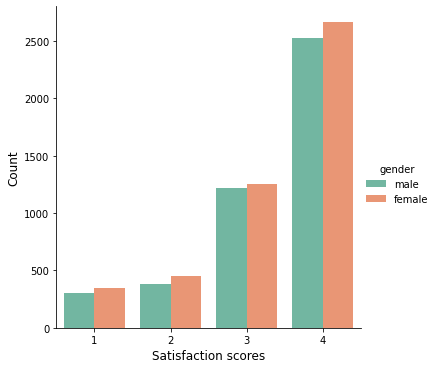

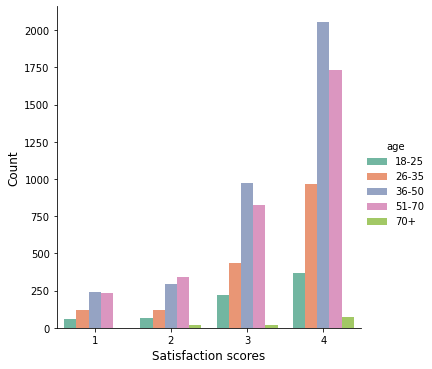

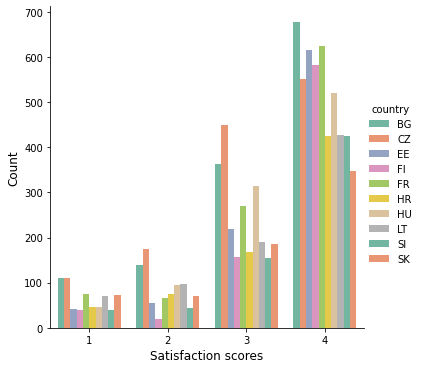

In [18]:
sf_gender_plot = sns.catplot(x="satisfaction", kind = 'count', hue= "gender", data=df_final, palette = 'Set2')
plt.xlabel('Satisfaction scores', fontsize=12)
plt.ylabel('Count', fontsize=12)

hue_order = ['18-25', '26-35', '36-50', '51-70', '70+']
sf_age_plot = sns.catplot(x="satisfaction", kind = 'count', hue= "age", hue_order = hue_order, data=df_final, palette = 'Set2')
plt.xlabel('Satisfaction scores', fontsize=12)
plt.ylabel('Count', fontsize=12)

sf_country_plot = sns.catplot(x="satisfaction", kind = 'count', hue= "country", data=df_final, palette = 'Set2')
plt.xlabel('Satisfaction scores', fontsize=12)
plt.ylabel('Count', fontsize=12)

<font size="6">
    3. Split train and test

In [19]:
##Split data into train and test
features = ['agea','hinctnta','eisced', 'eduyrs', 'sclmeet', 
                       'wrkhome', 'c19whome', 'wrklong', 'wrkresp', 'c19whacc', 
                       'mansupp','manwrkpl', 'manspeak', 'manscrn', 'manphone',
                       'mancom','teamfeel','wrkextra', 'colprop', 'colspeak', 'colphone', 'colcom', 'c19spwrk', 'c19mcwrk',
                       'mcwrkhom', 'uemp3m', 'emplrel',
                       'hincfel', 'trdawrk','jbprtfp', 'pfmfdjba', 'dcsfwrka',  'manhlp',  'colhlp']
target = ['satisfaction']

X = data[features]
y = data[target]
test_size = 0.2
X_train, X_test_final, y_train, y_test_final = train_test_split(X, y, test_size = test_size, random_state =0)
#sc = StandardScaler()
data.head()



,cntry,agea,hinctnta,eisced,hhmmb,eduyrs,sclmeet,wrkhome,c19whome,wrklong,...,pfmfdjba,dcsfwrka,c19wplch,manhlp,colhlp,missing,satisfaction,age,gender,country
1,BG,43.0,8.0,6.0,4.0,16.0,7.0,1.0,2.0,6.0,...,3.0,3.0,2.0,1.0,3.0,10,4,36-50,male,BG
2,BG,50.0,7.0,7.0,1.0,16.0,4.0,4.0,3.0,6.0,...,3.0,1.0,1.0,1.0,2.0,12,2,36-50,female,BG
3,BG,51.0,6.0,4.0,3.0,11.0,4.0,6.0,3.0,5.0,...,3.0,1.0,1.0,2.0,2.0,10,3,51-70,female,BG
4,BG,70.0,4.0,7.0,2.0,17.0,4.0,6.0,3.0,5.0,...,3.0,1.0,1.0,2.0,1.0,8,1,51-70,male,BG
7,BG,48.0,4.0,4.0,2.0,12.0,3.0,6.0,3.0,5.0,...,3.0,1.0,1.0,1.0,1.0,11,3,36-50,male,BG


In [20]:
print(np.shape(X_test_final))
print(np.shape(y_test_final))
print(np.shape(X_train))
print(np.shape(y_train))

(1831, 41)
(1831, 1)
(7321, 41)
(7321, 1)


<font size="6">
   4.  Undersampling

In [21]:

undersample = RandomUnderSampler(sampling_strategy = 'all')
X_train_undersampled, y_train_undersampled = undersample.fit_resample(X_train, y_train)
data_undersampled = X_train_undersampled.copy()
data_undersampled['y_train_undersampled'] = y_train_undersampled.copy()
print("After", Counter(data_undersampled.y_train_undersampled))

After Counter({1: 520, 2: 520, 3: 520, 4: 520})


In [22]:
df = data_undersampled

<font size="6."> 5. Functions ordinal classification</font>
<br>



<font size="6"> 5a. Download functions</font>
<br>



In [23]:
!make

make -e -C classifiers/libsvmRank/python
make[1]: Entering directory '/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/classifiers/libsvmRank/python'
python setup.py build_ext --inplace && rm -f redsvm.cpp && rm -Rf build
running build_ext
make[1]: Leaving directory '/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/classifiers/libsvmRank/python'
make -e -C classifiers/svorex
make[1]: Entering directory '/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/classifiers/svorex'
python setup.py build_ext --inplace && rm -f svorex.cpp && rm -Rf build
running build_ext
make[1]: Leaving directory '/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/classifiers/svorex'


In [24]:
!python config.py with configurations/single_test.json seed=12345 -l ERROR


###############################
	Running Experiment
###############################

Running tae dataset
--------------------------
Running SVMOP ...
  Running Partition 0
  Running Partition 1
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 2
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 3
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previou


Running balance-scale dataset
--------------------------
Running SVMOP ...
  Running Partition 0
  Running Partition 1
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 2
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 3
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 4
/Users/jolijneikelboom/Library/CloudS


Running contact-lenses dataset
--------------------------
Running SVMOP ...
  Running Partition 0
  Running Partition 1
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 2
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 3
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 4
/Users/jolijneikelboom/Library/Cloud

In [25]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

In [26]:
X_train_undersampled.isnull().values.any()

False

<font size="6">5b. Apply functions</font>
<br>



<font size="5">
    5.b.1. CSV1V1 
<font size="3">    
    Why use neg_mean_absolute_error: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [27]:
param_grid = {'estimator__C': [0.01, 0.1, 1, 10], 'estimator__gamma': [10, 1,0.1, 0.01]}
model = SVC(decision_function_shape = 'ovo')
ovo = OneVsOneClassifier(model)
ovo_gscv = GridSearchCV(ovo, param_grid, scoring = 'neg_mean_absolute_error', return_train_score = True, cv = 4, verbose = 3)
ovo_gscv.fit(X_train_undersampled, y_train_undersampled) #je fit hem op de undersamplede data

print(ovo_gscv.best_params_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4] END ..........estimator__C=0.1, estimator__gamma=10; total time=   1.7s
[CV 2/4] END ..........estimator__C=0.1, estimator__gamma=10; total time=   1.5s
[CV 3/4] END ..........estimator__C=0.1, estimator__gamma=10; total time=   1.6s
[CV 4/4] END ..........estimator__C=0.1, estimator__gamma=10; total time=   1.4s
[CV 1/4] END ...........estimator__C=0.1, estimator__gamma=1; total time=   1.4s
[CV 2/4] END ...........estimator__C=0.1, estimator__gamma=1; total time=   1.5s
[CV 3/4] END ...........estimator__C=0.1, estimator__gamma=1; total time=   1.3s
[CV 4/4] END ...........estimator__C=0.1, estimator__gamma=1; total time=   1.4s
[CV 1/4] END .........estimator__C=0.1, estimator__gamma=0.1; total time=   1.3s
[CV 2/4] END .........estimator__C=0.1, estimator__gamma=0.1; total time=   1.3s
[CV 3/4] END .........estimator__C=0.1, estimator__gamma=0.1; total time=   1.2s
[CV 4/4] END .........estimator__C=0.1, estimator

In [28]:

ovo_gscv_predictions = ovo_gscv.predict(X_test_final) 
ovo_gscv_df = X_test_final.copy()
ovo_gscv_df.insert(41, 'Actual', y_test_final, True)
ovo_gscv_df.insert(41, 'Predicted', ovo_gscv_predictions, True)

list_true_scores = list(ovo_gscv_df['Actual'])
list_ovo_gscv_predicted = list(ovo_gscv_df['Predicted'])

ovo_gscv_df.head()

,agea,hinctnta,eisced,hhmmb,eduyrs,sclmeet,wrkhome,c19whome,wrklong,wrkresp,...,trdawrk,jbprtfp,pfmfdjba,dcsfwrka,c19wplch,manhlp,colhlp,colscrn,Predicted,Actual
6190,30.0,10.0,7.0,2.0,17.0,6.0,2.0,1.0,4.0,5.0,...,3.0,2.0,1.0,3.0,2.0,1.0,1.0,1.0,1,4
7096,47.0,7.0,4.0,4.0,13.0,6.0,3.0,3.0,5.0,5.0,...,4.0,4.0,4.0,3.0,1.0,1.0,1.0,3.0,2,3
17615,33.0,8.0,4.0,1.0,13.0,4.0,6.0,3.0,6.0,1.0,...,3.0,4.0,3.0,1.0,1.0,2.0,2.0,3.0,1,3
9846,17.0,10.0,2.0,3.0,12.0,7.0,6.0,3.0,4.0,6.0,...,3.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,1,4
1094,41.0,9.0,4.0,6.0,12.0,6.0,5.0,3.0,4.0,3.0,...,3.0,3.0,2.0,1.0,1.0,2.0,1.0,3.0,1,3


print(ovo_gscv_df.Actual)

In [29]:
print(y_train.value_counts())
print(y_train_undersampled.value_counts())
print(y_test_final.value_counts())

satisfaction
4               4113
3               2016
2                672
1                520
dtype: int64
satisfaction
1               520
2               520
3               520
4               520
dtype: int64
satisfaction
4               1082
3                453
2                163
1                133
dtype: int64


In [30]:
ovo_gscv_true = ovo_gscv_df.Actual
ovo_gscv_predicted = ovo_gscv_df.Predicted

def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

print('Mae SCV1V1 after gridsearch', mae(ovo_gscv_true, ovo_gscv_predicted))
print('The best estimators:', ovo_gscv.best_estimator_)
mae_ovo_gscv = mae(ovo_gscv_true, ovo_gscv_predicted)

Mae SCV1V1 after gridsearch 1.3555434188967777
The best estimators: OneVsOneClassifier(estimator=SVC(C=1, decision_function_shape='ovo', gamma=0.1))


[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'True')]


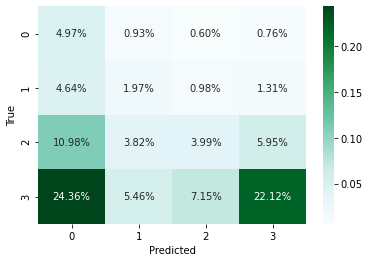

In [31]:
##CM with percentages
ovo_cf_matrix = confusion_matrix(ovo_gscv_true, ovo_gscv_predicted)
##CM with Percentages
ovo_ax = sns.heatmap(ovo_cf_matrix/np.sum(ovo_cf_matrix), annot=True, 
            fmt='.2%', cmap= 'BuGn')
print(ovo_ax.set(xlabel='Predicted', ylabel='True'))

In [32]:
true_scores = ovo_gscv_df.Actual.copy()
print('mae is', mae(true_scores, ovo_gscv_predictions))

mae is 1.3555434188967777


In [33]:
print('mze is', zero_one_loss(true_scores, ovo_gscv_predictions))

mze is 0.669579464773348


In [34]:
true_scores = ovo_gscv_df.Actual.copy()
print(len(true_scores))

1831


<font size="5">
    5.b.2. SVMOP

In [35]:
path.append('classifiers')
svmopModule = __import__("OrdinalDecomposition")
svmop= svmopModule.OrdinalDecomposition

In [36]:
parameter_list_C = [0.01, 0.1, 1, 10 ]
parameter_list_Gamma = [0.01, 0.1, 1, 10]

kf = KFold(n_splits=4, random_state=None, shuffle=False)

#kf.split split en geeft indexes van X en y voor elke split.  
#loc gebruikt namen, iloc gebruikt index



for C in parameter_list_C:
    for G in parameter_list_Gamma: #Hier gaat die dus voor de value van C, over elk van G. 
        print(f'C is nu: {C}, G is nu {G}')
        svmop_gscv = svmop(dtype = 'ordered_partitions', 
                              decision_method = 'frank_hall', 
                               base_classifier = 'sklearn.svm.SVC', 
                               parameters={'C': C,
                                           'gamma':G, 
                                           'probability':True})
        mae_fold = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
            y_train, y_test = y.iloc[train_index,], y.iloc[test_index,]
            svmop_gscv_fit = svmop_gscv.fit(X_train, y_train)
            svmop_gscv_predictions = svmop_gscv.predict(X_test)
            real_scores_svmop = list(y_test['satisfaction'])
            mae_in_between = mae(real_scores_svmop, svmop_gscv_predictions)
            mae_fold += mae_in_between
            print(mae_in_between)
        print('belonging mae is:', mae_fold /4)
    

In [37]:
svmop_best = svmop(dtype = 'ordered_partitions', 
                               decision_method = 'frank_hall', 
                               base_classifier = 'sklearn.svm.SVC', 
                               parameters={'C': 1,
                                           'gamma': 0.01, 
                                           'probability':True})
svmop_best.fit(X_train_undersampled, y_train_undersampled)
svmop_best_predictions = svmop_best.predict(X_test_final)



[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'True')]


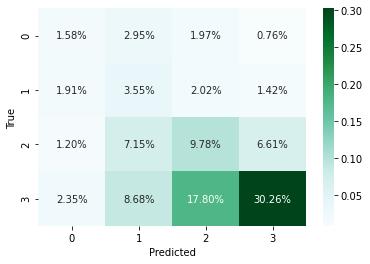

In [38]:
svmop_cf_matrix = confusion_matrix(true_scores, svmop_best_predictions)

svmop_ax = sns.heatmap(svmop_cf_matrix/np.sum(svmop_cf_matrix), annot=True, 
            fmt='.2%', cmap='BuGn')
print(svmop_ax.set(xlabel='Predicted', ylabel='True'))

In [39]:
print('mae is', mae(true_scores, svmop_best_predictions))
print('mze is', zero_one_loss(true_scores, svmop_best_predictions))

mae is 0.7433096668487166
mze is 0.5483342435827416


<font size="5">
    5.b.3. SVOREX

In [40]:
path.append('classifiers')
svorexModule = __import__("SVOREX")
svorex= svorexModule.SVOREX

In [41]:
valuesC = [0.01, 0.1, 1, 10]

#SVOREX with selfmade gridsearch CV to check if it gives the same result --> does not, bij deze middelt die niet
for C in valuesC:
    for K in valuesK: #Hier gaat die dus voor de value van C, over elk van K. 
        print(f'C is nu: {C}')
        svorex_gscv = svorex(c = C)
        mae_fold = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
            y_train, y_test = y.iloc[train_index,], y.iloc[test_index,]
            svorex_gscv_fit = svorex_gscv.fit(X_train, y_train)
            svorex_gscv_predictions = svorex_gscv.predict(X_test)
            real_scores_svorex = list(y_test['satisfaction'])
            mae_fold += mae(y_test, svorex_gscv_predictions)
            print(mae(y_test, SVOREX_gscv_predictions))
        print('belonging mae is:', mae_fold /4 )
        

In [42]:
svorex_best = svorex(c = 1)
svorex_best.fit(X_train_undersampled, y_train_undersampled)
svorex_best_predictions = svorex_best.predict(X_test_final)

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'True')]


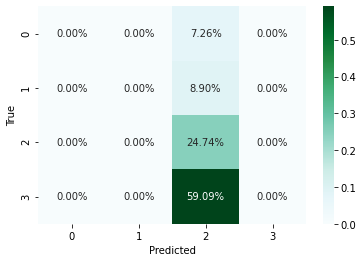

In [43]:
svorex_cf_matrix = confusion_matrix(y_test_final, svorex_best_predictions)
##CM with Percentages
svorex_new = sns.heatmap(svorex_cf_matrix/np.sum(svorex_cf_matrix), annot=True, 
            fmt='.2%', cmap='BuGn')
print(svorex_new.set(xlabel='Predicted', ylabel='True'))



In [44]:
print(mae(y_test_final, svorex_best_predictions))
print(zero_one_loss(y_test_final, svorex_best_predictions))

0.8252321135991262
0.752594210813763


<font size="5">
    5.b.4. REDSVM

In [45]:
path.append('classifiers')
redsvmModule = __import__("REDSVM")
redsvm = redsvmModule.REDSVM
valuesG = [0.01, 0.1, 1, 10]
valuesc = [0.01, 0.1, 1, 10]
kf = KFold(n_splits=4, random_state=None, shuffle=False)

##make REDSVM gridsearch by yourself.
for C in valuesc:
    for G in valuesG: #Hier gaat die dus voor de value van C, over elk van G. 
        print(f'C is nu: {C}, g is nu {G}')
        redsvm_gscv = redsvm(c = C, g = G)
        mae_fold = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
            y_train, y_test = y.iloc[train_index,], y.iloc[test_index,]
            redsvm_gscv_fit = redsvm_gscv.fit(X_train, y_train)
            redsvm_gscv_predictions = redsvm_gscv.predict(X_test)
            real_scores_redsvm = list(y_test['satisfaction']) 
            mae_fold += mae(y_test, redsvm_gscv_predictions)
            print(mae(y_test, redsvm_gscv_predictions))
        print('belonging mae is:', mae_fold /4 )


In [47]:
redsvm_best = redsvm(c = 0.1, g =1)
redsvm_best_fit = redsvm_best.fit(X_train_undersampled, y_train_undersampled)
redsvm_best_predictions = redsvm_best.predict(X_test_final)

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'True')]


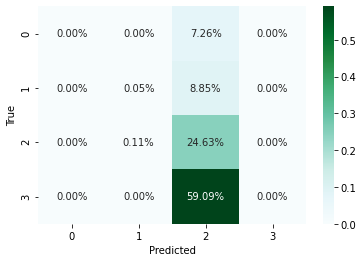

In [48]:
redsvm_cf_matrix = confusion_matrix(y_test_final, redsvm_best_predictions)
##CM with Percentages
redsvm_ax = sns.heatmap(redsvm_cf_matrix/np.sum(redsvm_cf_matrix), annot=True, 
            fmt='.2%', cmap='BuGn')

print(redsvm_ax.set(xlabel='Predicted', ylabel='True'))

In [49]:
print(mae(y_test_final, redsvm_best_predictions))
print(zero_one_loss(y_test_final, redsvm_best_predictions))

0.8263408182580422
0.7531403604587656


In [50]:
print(mae(true_scores, ovo_gscv_predictions))
print(mae(true_scores, svmop_best_predictions))
print(mae(true_scores, redsvm_best_predictions))
print(mae(true_scores, redsvm_best_predictions))

1.5411543593091968
0.7433096668487166
0.8257782632441288
0.8257782632441288


<font size="6">
5.c Comparison of models

How to apply wilcoxon test:
1.  You need a list which values represent the differences between two groups.
2. In my case, that list should thus compare the error of one model with the error of another model, for every instance. HOW:
    a. make a column that shows error for every model. (example: error_ovo = abs(ovo_predicted - true)
    b. make a list that compares two of those columns. (example: differences = error_ovo - error_svmop).
    c. Now you have the list that compares the errors, as required by step 2. 
3. This list can be put into the wilcoxon test. The wilcoxon takes the list of differences and produces a statistic and p.value.

For example on other dataset see link.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html

differences_ovo_svmop = list(ovo_gscv_predictions - svmop_best_predictions)
differences_ovo_svorex = list(ovo_gscv_predictions - svorex_best_predictions)
differences_ovo_redsvm = list(ovo_gscv_predictions - redsvm_best_predictions)
differences_svmop_svorex = list(svmop_best_predictions - svorex_best_predictions)
differences_svmop_redsvm = list(svmop_best_predictions - redsvm_best_predictions)
differences_svorex_redsvm = list(svmop_best_predictions - redsvm_best_predictions)

test_ovo_svmop = wilcoxon(differences_ovo_svmop)
print('ovo compared to svmop results: statistic is:', test_ovo_svmop.statistic, 
      'p is', test_ovo_svmop.pvalue)

test_ovo_svorex = wilcoxon(differences_ovo_svorex)
print('ovo compared to svorex results: statistic is:', test_ovo_svorex.statistic, 
      'p is', test_ovo_svorex.pvalue)

test_ovo_redsvm = wilcoxon(differences_ovo_redsvm)
print('ovo compared to redsvm results: statistic is:', test_ovo_redsvm.statistic, 
      'p is', test_ovo_redsvm.pvalue)

test_svmop_svorex = wilcoxon(differences_svmop_svorex)
print('svmop compared to svorex results: statistic is:', test_svmop_svorex.statistic, 
      'p is', test_svmop_svorex.pvalue)

test_svmop_redsvm = wilcoxon(differences_svmop_redsvm)
print('svmop compared to redsvm results: statistic is:', test_svmop_redsvm.statistic, 
      'p is', test_svmop_redsvm.pvalue)

test_svorex_redsvm = wilcoxon(differences_svorex_redsvm)
print('svorex compared to redsvm results: statistic is:', test_svorex_redsvm.statistic, 
      'p is', test_svorex_redsvm.pvalue)

In [60]:
error_ovo = abs(ovo_gscv_predictions - list_true_scores)
error_svmop = abs(svmop_best_predictions - list_true_scores)
error_svorex = abs(np.array(svorex_best_predictions) - np.array(list_true_scores))
error_redsvm = abs(np.array(redsvm_best_predictions) - np.array(list_true_scores))


differences_error_ovo_svmop = list(error_ovo - error_svmop)
differences_error_ovo_svorex = list(error_ovo - error_svorex)
differences_error_ovo_redsvm = list(error_ovo - error_redsvm)
differences_error_svmop_svorex = list(error_svmop - error_svorex)
differences_error_svmop_redsvm = list(error_svmop - error_redsvm)
differences_error_svorex_redsvm = list(error_svorex - error_redsvm)

true_list = list(true_scores)

In [61]:
test_ovo_svmop = wilcoxon(differences_error_ovo_svmop)
print('ovo compared to svmop results: statistic is:', test_ovo_svmop.statistic, 
      'p is', test_ovo_svmop.pvalue)

test_ovo_svorex = wilcoxon(differences_error_ovo_svorex)
print('ovo compared to svorex results: statistic is:', test_ovo_svorex.statistic, 
      'p is', test_ovo_svorex.pvalue)

test_ovo_redsvm = wilcoxon(differences_error_ovo_redsvm)
print('ovo compared to redsvm results: statistic is:', test_ovo_redsvm.statistic, 
      'p is', test_ovo_redsvm.pvalue)

test_svmop_svorex = wilcoxon(differences_error_svmop_svorex)
print('svmop compared to svorex results: statistic is:', test_svmop_svorex.statistic, 
      'p is', test_svmop_svorex.pvalue)

test_svmop_redsvm = wilcoxon(differences_error_svmop_redsvm)
print('svmop compared to redsvm results: statistic is:', test_svmop_redsvm.statistic, 
      'p is', test_svmop_redsvm.pvalue)

test_svorex_redsvm = wilcoxon(differences_error_svorex_redsvm)
print('svorex compared to redsvm results: statistic is:', test_svorex_redsvm.statistic, 
      'p is', test_svorex_redsvm.pvalue)

ovo compared to svmop results: statistic is: 94994.0 p is 6.5249077545956694e-80
ovo compared to svorex results: statistic is: 281853.5 p is 7.006079044769036e-70
ovo compared to redsvm results: statistic is: 281100.5 p is 8.537415106475889e-70
svmop compared to svorex results: statistic is: 329835.0 p is 0.00017222036525133344
svmop compared to redsvm results: statistic is: 327841.5 p is 0.00015335383638638464
svorex compared to redsvm results: statistic is: 2.0 p is 0.5637028616507731
